In [9]:
from flat import document, rgb, rgba, font, strike, shape
from flat.command import moveto, quadto, curveto, lineto, closepath
from bezmerizing import Polyline, Path
import numpy as np
import math
from copy import copy
from numpy.random import uniform, normal, choice
from IPython.display import SVG, display  # Scalable Vector Graphics, SVG

In [10]:
def show(page):
    display(SVG(page.svg()))

In [11]:
def glyphcommands(f, ch):
    return Path([copy(cmd) for cmd in f.glyph(f.charmap[ord(ch)])])

In [12]:
def advancefor(f, ch):
    return f.advances[f.charmap[ord(ch)]]

In [13]:
f = font.open("fonts/TmoneyRoundWindExtraBold.ttf")
print("폰트명:", f.name)
print("Density:", f.density)

폰트명: b'TmoneyRoundWind-ExtraBold'
Density: 1000


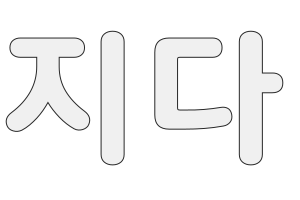

In [14]:
gu_path_orig = glyphcommands(f, "지")
reum_path_orig = glyphcommands(f, "다")

page = document(300, 200, 'pt').addpage()
pen = shape().stroke(rgb(40, 40, 40)).fill(rgb(240, 240, 240))
page.place(pen.path(gu_path_orig.scale(144/f.density).translate(0, 144)))
page.place(pen.path(reum_path_orig.scale(144/f.density).translate(144, 144)))
show(page)

In [15]:
def get_dir_of_glyph(cmd, pre_x, pre_y):
    
    direct = ""    
    if type(cmd) == moveto:
        direct += "start"
        return direct
    
    if cmd.x > pre_x:
        direct += "right"
    elif cmd.x < pre_x:
        direct += "left"
    else:
        direct += ""
    
    if cmd.y > pre_y:
        direct += "down"
    elif cmd.y < pre_y:
        direct += "up"
    else:
        direct += ""
        
   
    return direct

In [16]:
def get_dir_list(path):
    dir_list = []
    
    pre_x, pre_y = -9999, -9999
    for idx, cmd in enumerate(path):
        if type(cmd) == moveto:
            pre_x = cmd.x
            pre_y = cmd.y
            direct = get_dir_of_glyph(cmd, pre_x, pre_y)
            dir_list.append(direct)
        elif type(cmd) in (lineto, quadto, curveto):
            direct = get_dir_of_glyph(cmd, pre_x, pre_y)
            dir_list.append(direct)
            pre_x = cmd.x
            pre_y = cmd.y
        else:
            dir_list.append("fin")
    
    return dir_list

In [17]:
def cut_glyph(direct, num, path):
    # c를 리스트에 어펜드
    # num = 나누는 수
    result = []
    pre_x = -9999
    for idx, cmd in enumerate(path):

        if type(cmd) == moveto:
            pre_x, pre_y = cmd.x, cmd.y
            c = moveto(cmd.x,cmd.y)
            result.append(c)
        elif type(cmd) == lineto and direct[idx] == "left":
            glyph_length = math.sqrt((cmd.x - pre_x)**2 + (cmd.y - pre_y)**2)
            cut_num = int(glyph_length / 300) * 2 + 1
            for i in  range(1, cut_num+1):
                temp_x = pre_x + i * (cmd.x - pre_x) / cut_num
                c = lineto(temp_x, cmd.y)
                result.append(c)
            pre_x = cmd.x
        elif type(cmd) in (lineto, quadto, curveto):
            if type(cmd) == lineto:
                c = lineto(cmd.x, cmd.y)
                pre_x = cmd.x
            elif type(cmd) == quadto:
                c = copy(cmd)
            elif type(cmd) == curveto:
                c = copy(cmd)
            result.append(c)
        else:
            c = closepath
            result.append(c)
    return result

디자인

In [18]:
def mod_humidity_corrdinate_value(direct, mid_x, mid_y, av, cmd):
    
    c = copy(cmd)
    
    if direct.count('+')==1:  # 대각선
        c = copy(cmd)
        
    else:  
        if "left" in direct:
            c = quadto(x1=mid_x, y1=mid_y+av, x=cmd.x, y=cmd.y)
              
        else:
            c = copy(cmd)
    
    return c

In [19]:
def change_glyph_to_quad(cmd, direct, av, pre_x, pre_y):
    
    if type(cmd) == moveto:
        c = moveto(cmd.x, cmd.y)
    elif type(cmd) in (lineto, quadto, curveto):
        mid_x = (cmd.x + pre_x) / 2
        mid_y = (cmd.y + pre_y) / 2
        #print(direct,":", pre_x, "/", mid_x,"/", cmd.x)
        #print(direct,":", pre_y, mid_y, cmd.y)
        
        #디자인 적용
        c = mod_humidity_corrdinate_value(direct, mid_x, mid_y, av, cmd)
        
    else:
        c = closepath

    return c

In [20]:
def make_design_glyph(input_path, glyph_dir, av):
    pre_x = 0
    pre_y = 0

    design_glyph_list = []
    for idx, cmd in enumerate(input_path):
        if idx%2==1:
            if type(cmd) == moveto:
                pre_x = cmd.x
                pre_y = cmd.y
                c = change_glyph_to_quad(cmd, glyph_dir[idx], av, pre_x, pre_y)
            elif type(cmd) in (lineto, quadto, curveto):
                c = change_glyph_to_quad(cmd, glyph_dir[idx], av, pre_x, pre_y)
                pre_x = cmd.x
                pre_y = cmd.y
            else:
                c = closepath
                pre_x = 0
                pre_y = 0
        elif idx%2==0:
            if type(cmd) == moveto:
                pre_x = cmd.x
                pre_y = cmd.y
                c = change_glyph_to_quad(cmd, glyph_dir[idx], -av, pre_x, pre_y)
            elif type(cmd) in (lineto, quadto, curveto):
                c = change_glyph_to_quad(cmd, glyph_dir[idx], -av, pre_x, pre_y)
                pre_x = cmd.x
                pre_y = cmd.y
            else:
                c = closepath
                pre_x = 0
                pre_y = 0

        design_glyph_list.append(c)
        
    return design_glyph_list

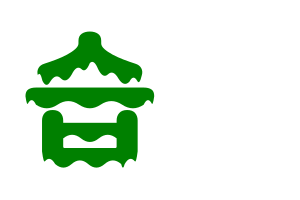

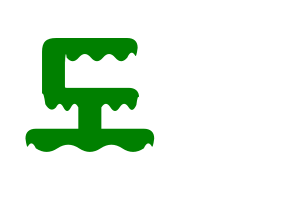

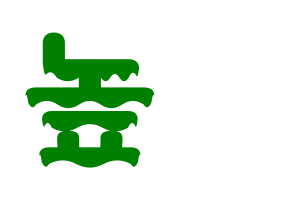

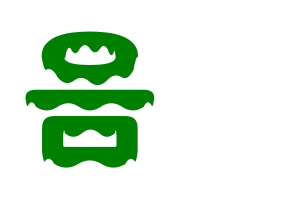

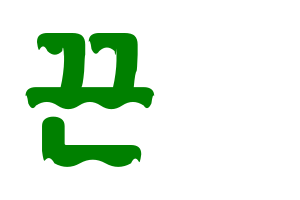

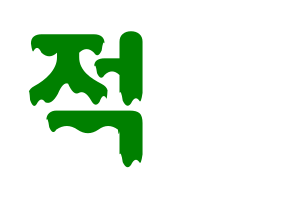

In [21]:
input_letters = ["습", "도", "높", "음", "끈", "적"]
#input_letters = ["적"]
av =50

for letter in input_letters:
   
    
    path_list = glyphcommands(f, letter)  
    #print("<<", letter, ">>")
    glyph_dir = get_dir_list(path_list) 

    mod_path = cut_glyph(glyph_dir, 6, path_list)
    
    glyph_path_direct = get_dir_list(mod_path)
    
    mod_glyph = make_design_glyph(mod_path, glyph_path_direct, av)
    mod_path2 = Path(mod_glyph)
    
    page = document(300, 200, 'pt').addpage()
    pen = shape().nostroke().fill(rgb(0, 128, 0))
    page.place(pen.path(mod_path2.scale(144/f.density).translate(20, 144)))
    show(page)